## C1 

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

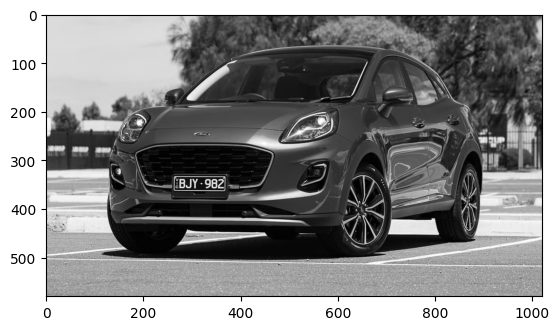

In [2]:
img = cv2.imread('../../data/image/image3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

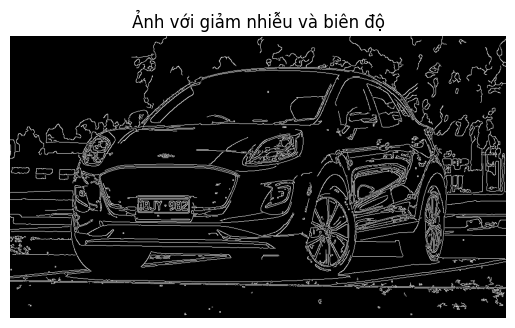

In [3]:
# Giảm nhiễu bằng bộ lọc bilateral
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)  # Tham số: (ảnh đầu vào, đường kính kernel, độ chính xác không gian, độ chính xác màu sắc)
# Phát hiện biên bằng phép nhận diện biên Canny
edged = cv2.Canny(bfilter, 30, 200)  # Tham số: (ảnh đầu vào, ngưỡng dưới, ngưỡng trên)
# Hiển thị ảnh kết quả
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.title("Ảnh với giảm nhiễu và biên độ")
plt.axis('off')  # Tắt trục x và y để thuận tiện khi hiển thị
plt.show()


In [4]:
# Tìm đường viền trong ảnh edged
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Trích xuất danh sách các đường viền từ kết quả
contours = imutils.grab_contours(keypoints)

# Sắp xếp danh sách các đường viền dựa trên diện tích (lớn đến nhỏ)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:20]

In [5]:
location = None  # Biến lưu trữ đỉnh của đường viền có 4 góc

# Duyệt qua danh sách các đường viền
for contour in contours:
    # Ước lượng đa giác xấp xỉ đường viền với độ chính xác là 10
    approx = cv2.approxPolyDP(contour, 10, True)
    
    # Kiểm tra xem đa giác xấp xỉ có 4 đỉnh hay không
    if len(approx) == 4:
        location = approx
        break  # Nếu tìm thấy, thoát khỏi vòng lặp

# Kết quả: Biến 'location' chứa đỉnh của đường viền có 4 góc (nếu có)

In [6]:
location

array([[[263, 334]],

       [[264, 363]],

       [[369, 362]],

       [[366, 333]]], dtype=int32)

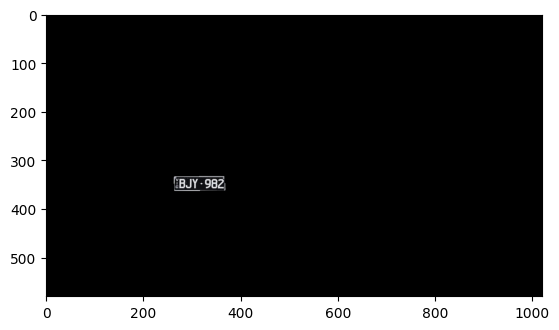

In [7]:
# Tạo một mask (mặt nạ) có kích thước giống với ảnh xám
mask = np.zeros(gray.shape, np.uint8)

# Vẽ đường viền đã tìm được lên mask với giá trị màu 255 (trắng)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)

# Áp dụng bitwise AND giữa ảnh gốc và mask để lấy phần của ảnh chỉ chứa đối tượng quan trọng
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

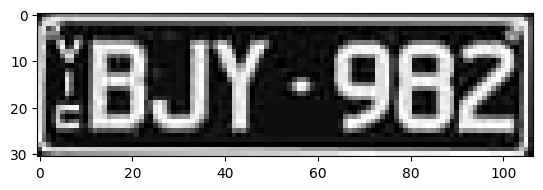

In [9]:
# Tìm vị trí (x, y) trong mask với giá trị là 255 (trắng)
(x, y) = np.where(mask == 255)

# Tìm giá trị tối thiểu và tối đa của x và y
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))

# Cắt ảnh gốc để chỉ giữ lại phần đã xác định bởi mask
cropped_image = gray[x1:x2 + 1, y1:y2 + 1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [11]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 2], [107, 2], [107, 31], [0, 31]], 'EBJY. 982]', 0.3741937983327902)]

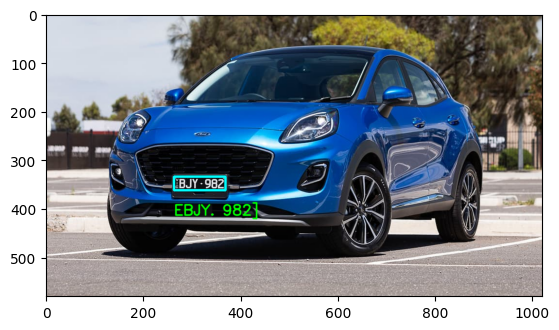

In [12]:
# Lấy nội dung từ kết quả (giả sử result là một danh sách chứa các kết quả)
text = result[0][-2]

# Chọn kiểu font (ví dụ: FONT_HERSHEY_SIMPLEX)
font = cv2.FONT_HERSHEY_SIMPLEX

# Thêm văn bản vào ảnh
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1] + 50), fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

# Vẽ hình chữ nhật quanh đối tượng
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (255, 255, 0), 3)

# Hiển thị ảnh kết quả
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [15]:
# # Đường dẫn để lưu ảnh (thay đổi đường dẫn và tên file theo ý muốn)
# save_path = "D:/study/CV/CK/speechcam_detection/output/plate/img_plate.png"

# # Lưu ảnh
# cv2.imwrite(save_path, res)

# # In ra thông báo lưu thành công
# print(f"Ảnh đã được lưu tại: {save_path}")


Ảnh đã được lưu tại: D:/study/CV/CK/speechcam_detection/output/plate/img_plate.png


---

## C2 : dùng yolo phát hiện biển số


In [49]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

license_plate_detector = YOLO('./license_plate_detector.pt')

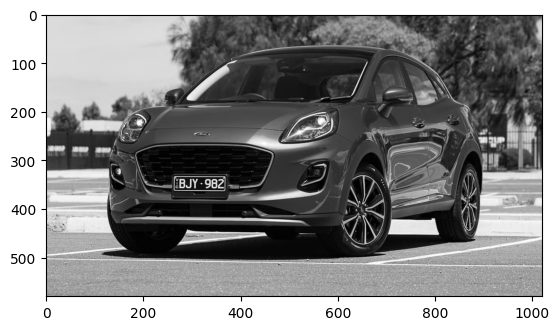

In [50]:
img = cv2.imread('../../data/image/image3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

# Xác định tọa độ biển số xe

In [51]:
x1, y1, x2, y2, score, class_id = license_plate_detector(img)[0].boxes.data.tolist()[0]
x1, y1, x2, y2, score, class_id


0: 384x640 1 license_plate, 110.0ms
Speed: 4.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


(252.89447021484375,
 325.11419677734375,
 381.67156982421875,
 372.70904541015625,
 0.691777765750885,
 0.0)

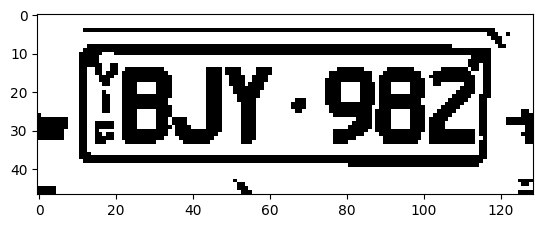

In [52]:
result = img[int(y1):int(y2), int(x1): int(x2), :]
license_plate_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
_, license_plate_thresh = cv2.threshold(license_plate_gray, 64, 255, cv2.THRESH_BINARY_INV) # chuyển về ảnh nhị phân
plt.imshow(cv2.cvtColor(license_plate_thresh, cv2.COLOR_BGR2RGB))

In [53]:
reader = easyocr.Reader(['en'])
result_plate = reader.readtext(license_plate_thresh)
result_plate[0][-2]

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


'BJY. 982'

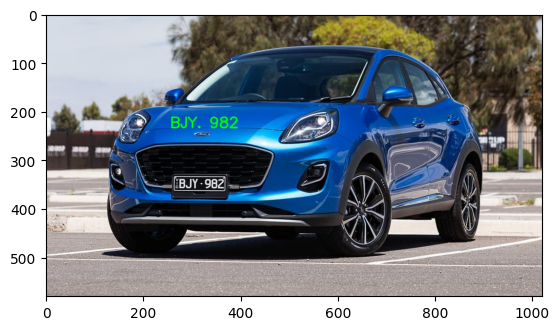

In [54]:
# Lấy nội dung từ kết quả (giả sử result là một danh sách chứa các kết quả)
text = result_plate[0][-2]

# Lấy kích thước của văn bản để xác định vị trí cần vẽ hộp chữ nhật
text_size = cv2.getTextSize(text, font, 1, 2)[0]
text_x = 255  # Tọa độ x của văn bản (thay đổi theo nhu cầu)
text_y = 255 - text_size[1]  # Tọa độ y của văn bản (thay đổi theo nhu cầu)

# Thêm văn bản vào ảnh
res = cv2.putText(img, text=text, org=(text_x, text_y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

# Tọa độ của góc trái trên và góc phải dưới của hình chữ nhật (thay đổi theo nhu cầu)
rectangle_top_left = (255, 255)
rectangle_bottom_right = (255 + text_size[0], 255 + text_size[1])

# Hiển thị ảnh kết quả
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))


In [55]:
# # Đường dẫn để lưu ảnh (thay đổi đường dẫn và tên file theo ý muốn)
# save_path = "D:/study/CV/CK/speechcam_detection/output/plate/img_plate1.png"

# # Lưu ảnh
# cv2.imwrite(save_path, res)

# # In ra thông báo lưu thành công
# print(f"Ảnh đã được lưu tại: {save_path}")


Ảnh đã được lưu tại: D:/study/CV/CK/speechcam_detection/output/plate/img_plate1.png
